# Assignment 4 - Clustering

### RBOT240 - Machine Learning

#### Instructor: Daniel Pineo &copy; 2021



## K-Means Clustering

In this assignment we're going to look at the K-means clustering algorithm from the reading material.  We're going to use the Expectation-Maximization (EM)algorithm to find the clusters.  The EM algorithm works by iterating back and forth betwen two steps: the E-step and the M-step.

**E-step**:  The algorithm updates the cluster membership, given the current cluster parameters.

**M-step**:  The algorithm updates the cluster parameters, given the current cluster membership

Please see the reading material [here](http://cs229.stanford.edu/notes2020spring/cs229-notes7a.pdf) for a brief description of the algorithm.  See PRML chapter 9 for a more in-depth description.

Please complete the sections as indicated.

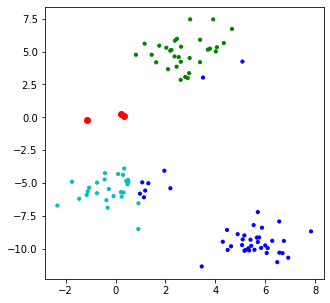

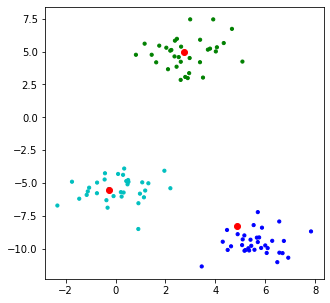

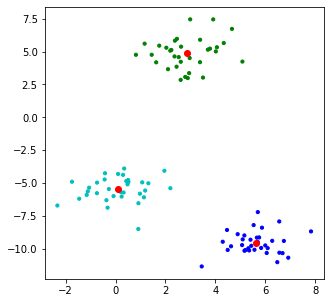

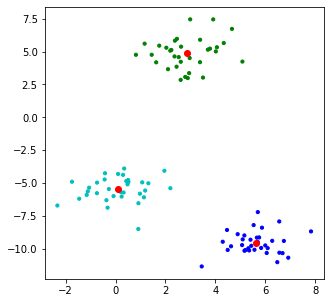

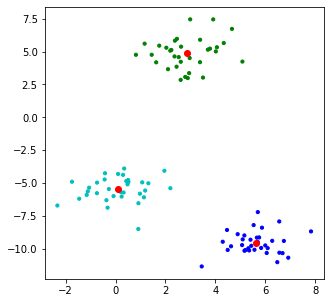

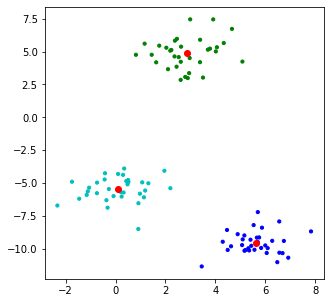

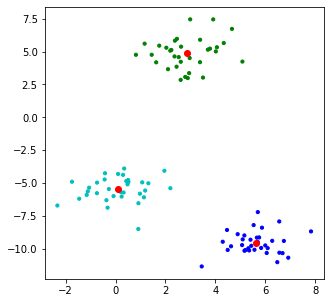

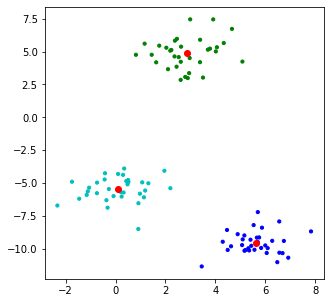

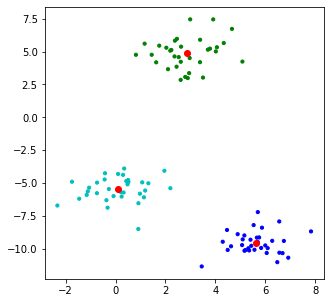

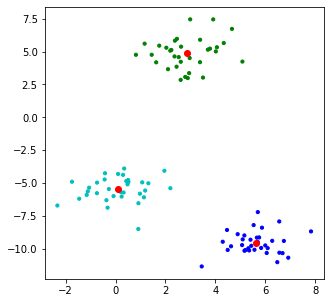

In [2]:
from sklearn import cluster, datasets
import numpy as np
import torch
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

colors = np.array(['b', 'g', 'c', 'm', 'y', 'k', 'w'])

X, y = datasets.make_blobs(n_samples=100, random_state=10)
X = torch.tensor(X).float()
   
cluster_means = torch.randn(3,2)

# Array to hold the distortion numbers for each iteration
distortions = []

for step in range(10):
        
    # E-Step
    # Compute cluster_indicator, the index of the closest cluster for each 
    # point.  You will need to compute the pairwise euclidean distances 
    # between all points in X and the cluster means.
    # (This is c^{(i)} in the CS229 reading materials)
    # (hint: remember about cdist!)

    ################################################
    ####### Place your implementation here #########
    ################################################
    pairwise_distance = torch.cdist(X, cluster_means, compute_mode='use_mm_for_euclid_dist_if_necessary')
    cluster_indicator = torch.min(pairwise_distance, 1).indices

    if step == 0:
        assert torch.allclose(cluster_indicator, torch.tensor([
          2, 2, 1, 0, 1, 1, 0, 2, 1, 0, 0, 1, 1, 0, 2, 1, 0, 0, 0, 1, 0, 0, 1, 0,
          0, 1, 1, 1, 1, 0, 2, 1, 1, 0, 2, 2, 0, 1, 1, 1, 2, 0, 2, 2, 1, 0, 0, 0,
          2, 0, 1, 0, 0, 0, 2, 0, 1, 2, 0, 0, 1, 0, 2, 2, 0, 0, 0, 2, 2, 2, 1, 0,
          1, 1, 2, 1, 1, 2, 0, 0, 0, 1, 0, 1, 2, 1, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2,
          1, 0, 0, 0])
        )
    
    plt.figure(figsize=(5,5))
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[cluster_indicator])
    plt.scatter(cluster_means[:,0], cluster_means[:,1], c='r')
    plt.show()

    # M-Step
    # Update the cluster means.  Each cluster should be updated to 
    # the average location of all points assigned to that cluster
    # If a cluster has no assigned points, leave it in place.
    # (This is \mu_j in the CS229 reading materials)

    # ################################################
    # ####### Place your implementation here #########
    # ################################################

    new_centers = [X[cluster_indicator == i].mean(0) for i in range(len(cluster_indicator))]
    new_centers = torch.stack(new_centers)
    new_centers = new_centers[~torch.any(new_centers.isnan(),dim=1)]

    # Update the cluster means
    cluster_means = new_centers


    # Distortion Function
    square_error_list = []
    for i in range(len(cluster_indicator)):
      cluster_np = X[cluster_indicator == i].numpy()
      if cluster_np.size > 0:
        mean = cluster_np.mean(0)
        square_error = np.linalg.norm(cluster_np - mean)**2 # squared of distance between the each point and it's centroid
        square_error_list.append(square_error) # append to list of squared errors for this cluster
    sum_square_error = np.sum(square_error_list) # sum all squared errors for this cluster (return scalar)
    distortions.append(sum_square_error) # append the sse number to the list of distortions for each iterations (Total number is 10)


    if step == 0:
      assert torch.allclose(cluster_means, torch.tensor([
          [ 4.8707, -8.2332],
          [ 2.7471,  4.9377],
          [-0.2652, -5.5191]
      ]), atol=1e-3
    )


Distortions Size
10
Distortions Numpy Array
668.2369210599848
186.36588149279305
186.36588149279305
186.36588149279305
186.36588149279305
186.36588149279305
186.36588149279305
186.36588149279305
186.36588149279305
186.36588149279305


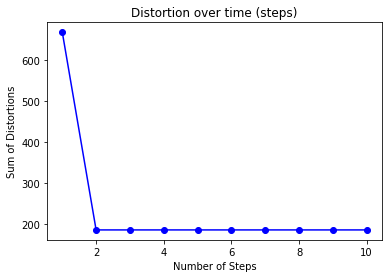

In [3]:
print('\033[34m' + '\033[1m' + 'Distortions Size' + '\033[0m')
print(len(distortions))
print('\033[34m' + '\033[1m' + 'Distortions Numpy Array' + '\033[0m')
print('\n'.join(str(x) for x in distortions))

# plot
plt.plot(range(1, len(distortions)+1), distortions, color='b', marker='o')
plt.xlabel('Number of Steps')
plt.ylabel('Sum of Distortions')
plt.title('Distortion over time (steps)')
plt.show()

## Gaussian Mixture Model

The Gaussian Mixture Model is quite related to K-means clustering.  It models the data via a superposition of Gaussian distributions.  Like the K-means clustering, we use the EM algorithm to fit the model.  The difference is that unlike the K-means model, the Gaussian Mixture Model also models the width of the clusters via the Gaussian covariance.

For this section, you'll want to reference the Gaussian Mixture Model reading materials [here](http://cs229.stanford.edu/notes2020spring/cs229-notes7b.pdf).


In [4]:
import math

log_norm_constant = -0.5 * math.log(2 * math.pi)


def log_gaussian(x, mean=0, var=0.):
    logvar = var.log()
    a = (x - mean) ** 2
    log_p = -0.5 * (logvar + a / logvar.exp())
    log_p = log_p + log_norm_constant
    return log_p.float()


# This sum is computed in an offset log space for stability
def logsumexp(x):
    max, _ = torch.max(x, dim=0, keepdim=True)
    return max + (x - max).exp().sum(dim=0, keepdim=True).log()


def get_posteriors(X, cluster_means, cluster_variances, cluster_probs):

    # get the likelihoods p(x|z) under the parameters
    # get feature-wise log-likelihoods (K, examples, features)
    log_likelihoods = log_gaussian(
        X[None, :, :], # (1, examples, features)
        cluster_means[:, None, :], # (K, 1, features)
        cluster_variances[:, None, :] # (K, 1, features)
    ) #* cluster_probs[:, None, None]
    
    # sum over the feature dimension
    log_likelihoods = log_likelihoods.sum(-1)
    return (log_likelihoods - logsumexp(log_likelihoods)).exp()    

Let's create some helper functions for visualizing the mixture model distributions

In [5]:
# Taken from: https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_clusters(cluster_means, cluster_variances):
    plt.figure(figsize=(6,6))
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])
    plt.scatter(X[:, 0], X[:, 1], s=10)
    for cluster_mean, cluster_variance in zip(cluster_means, cluster_variances):
        draw_ellipse(cluster_mean, .1*cluster_variance, alpha=.2)
    plt.show()


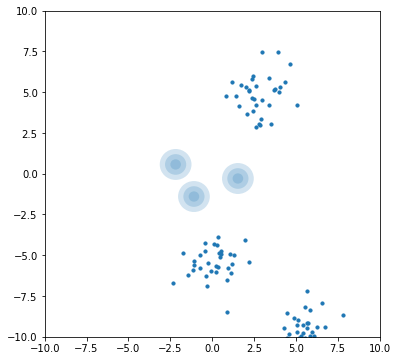

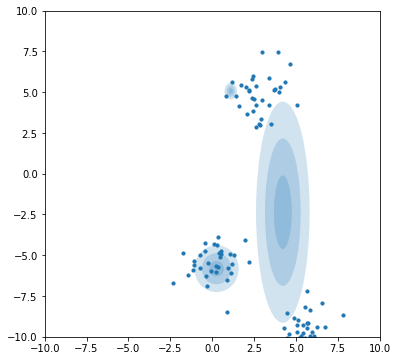

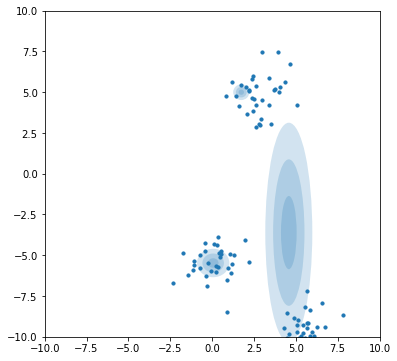

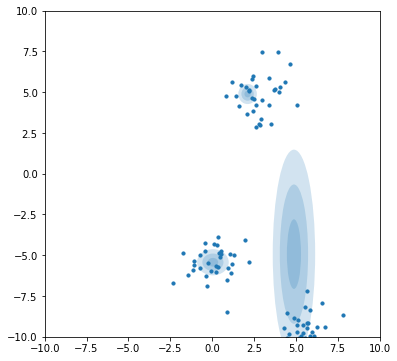

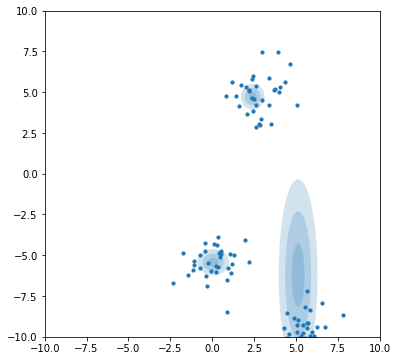

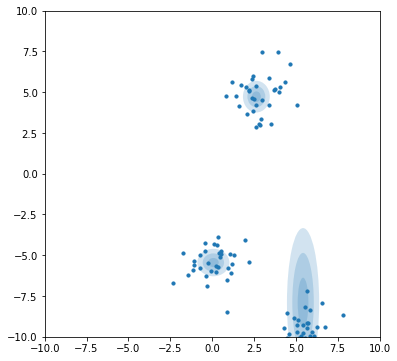

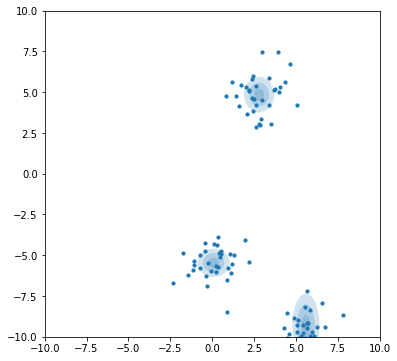

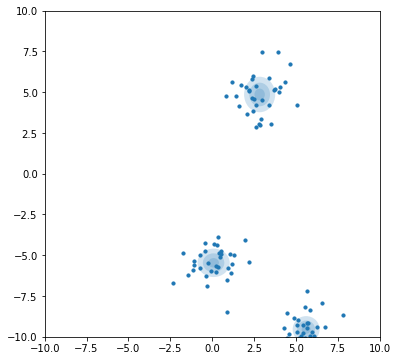

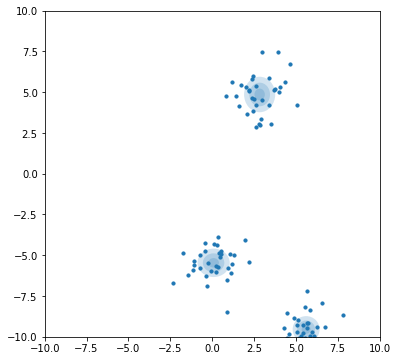

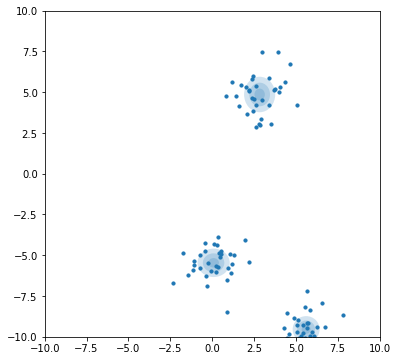

In [6]:
torch.manual_seed(0)
np.random.seed(0)

num_clusters = 3
d = 2

# Initialize means and variances
cluster_means = torch.randn(num_clusters,d)
cluster_variances = torch.ones(num_clusters, d)
cluster_probs = torch.ones(num_clusters) / num_clusters

for step in range(10):

    # E-Step
    # Compute the "soft" cluster assignments for each point: p(z|x)
    cluster_assignments = get_posteriors(X, cluster_means, cluster_variances, cluster_probs)

    plot_clusters(cluster_means, cluster_variances)

    # M-Step
    # Update parameters
    for c in range(len(cluster_means)):

        # Compute the sum of the soft assignments for this cluster
        # (This is \sum{\w_j^{(i)} in the CS229 lecture notes)
        # (hint: this will be used in the denominators of the later steps)

        ################################################
        ####### Place your implementation here #########
        ################################################
        cluster_assignments_sum = torch.sum(cluster_assignments[c], dim = 0)

        if step == 0 and c == 0:
            assert torch.isclose(cluster_assignments_sum, torch.tensor(65.7564))

        # Update cluster_prob[c], the updated probability for this cluster 
        # (This is \phi_j in the CS229 lecture notes)

        ################################################
        ####### Place your implementation here #########
        ################################################
        cluster_probs[c] = cluster_assignments_sum / num_clusters

        if step == 0 and c == 0:
            assert torch.isclose(cluster_probs[c], torch.tensor(21.9188))

        # Update the cluster_means[c], the mean position for this cluster
        # (This is \mu_j in the CS229 lecture notes)

        # ################################################
        # ####### Place your implementation here #########
        # ################################################
        cluster_means[c] = torch.sum(cluster_assignments[c].reshape(len(X),1) * X, dim=0) / cluster_assignments_sum

        if step == 0 and c == 0:
            assert torch.allclose(cluster_means[c], torch.tensor([ 4.2249, -2.3594]), atol=1e-3)


        # # Update cluster_variances[c], the variance for this cluster
        # # (This is \Sigma_j in the CS229 lecture notes)

        # ################################################
        # ####### Place your implementation here #########
        # ################################################
        a = X - cluster_means[c]
        cluster_variances[c] = (cluster_assignments[c] @ a**2) / cluster_assignments_sum

        if step == 0 and c == 0:
            assert torch.allclose(cluster_variances[c], torch.tensor([ 2.8542, 51.0971]), atol=1e-3)
